In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read words 
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'daisuke']

In [9]:
# build the vocab of chars and mapping to/from int
chars = sorted(list(set(''.join(words))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(itos, len(chars))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 26


In [10]:
block_size = 3 
def build_dataset(words):

    X_input, Y_label = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X_input.append(context)
            Y_label.append(ix)
            context = context[1:] + [ix] # crop and append

    X_input = torch.tensor(X_input, dtype=torch.int64)
    Y_label = torch.tensor(Y_label, dtype=torch.int64)
    print(X_input.shape, Y_label.shape)
    return X_input, Y_label

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182540, 3]) torch.Size([182540])
torch.Size([22936, 3]) torch.Size([22936])
torch.Size([22678, 3]) torch.Size([22678])


In [11]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNormId:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running momentum uddate)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # training mode
            x_mean = x.mean(0, keepdim=True) # batch mean
            x_var = x.var(0, keepdim=True) # batch variance
        else:
            # evaluation mode
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # update buffers
        if self.training:
            self.running_mean = self.momentum * x_mean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * x_var + (1 - self.momentum) * self.running_var

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
        def __call__(self, x):
            self.out = torch.tanh(x)
            return self.out
    
        def parameters(self):
            return []


In [12]:
torch.manual_seed(42)

In [15]:
n_emb = 10 # the dimentionality of the embedding vectors 
n_hidden = 100 # the number of hidden units

C = torch.randn((vocab_size, n_emb)) # the embedding matrix
layers = [
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNormId(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 1.0 # 5/3, batch normを使わないときの初期値gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

6197


In [16]:
batch_size = 32
lossi = []
max_steps = 200000

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch of X and Y

    # forward pass
    emb = C[Xb] # embedding the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # tracking stats
    # lri.append(lrp[i])
    if i % 10000 == 0:
        print(f"{i:7d}: {max_steps:7d} {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0:  200000 3.3511
  10000:  200000 2.3333
  20000:  200000 2.1959
  30000:  200000 2.1955
  40000:  200000 1.7435
  50000:  200000 2.2480
  60000:  200000 1.7787
  70000:  200000 2.3658
  80000:  200000 2.2404
  90000:  200000 2.1787
 100000:  200000 2.1350
 110000:  200000 1.7094
 120000:  200000 2.2768
 130000:  200000 2.2119
 140000:  200000 2.2972
 150000:  200000 2.1882
 160000:  200000 1.6255
 170000:  200000 2.3030
 180000:  200000 1.7878
 190000:  200000 2.2071


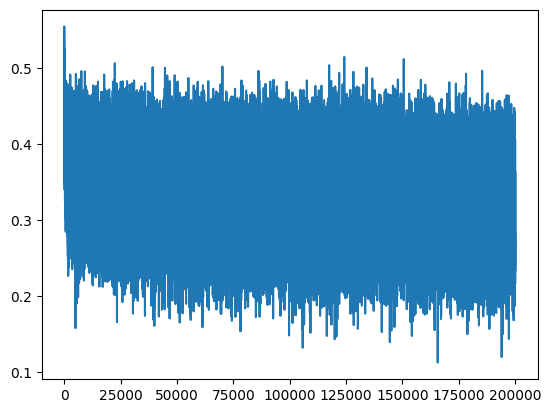

In [20]:
plt.plot(lossi)

In [17]:
for layer in layers:
    layer.training = False

In [18]:
@torch.no_grad() # no need to track gradients, evaluating alone makes it faster
def split_loss(split):
    x, y = {
        'traing': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1) # concatenate into (batch_size, n_emb * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print (f"{split} loss: {loss.item():.4f}")

split_loss('traing')
split_loss('val')

traing loss: 2.1065
val loss: 2.1417


In [19]:
# sample from the model
g = torch.Generator().manual_seed(214483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # start with all ... (zeros)
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x # (1, n_vocab)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context and append the new char
        context = context[1:] + [ix]
        out.append(ix)
        # if we hit the end of the word(special token), stop
        if ix == 0:
            break

    print("".join(itos[i] for i in out)) # decord and print the word

jah.
kymerysonina.
masyn.
nis.
haf.
kasee.
hawnadhim.
anna.
kamorre.
per.
makethanel.
leonia.
had.
kaime.
pensleli.
arlin.
colbriah.
kaylis.
alennionina.
jan.
